# Class Confusion Widget
This widget was designed to help extrapolate your models decisions through visuals such as graphs or confusion matrices that go more in-depth than the standard `plot_confusion_matrix`. Class Confusion can be used with **both** Tabular and Image classification models. (Note: Due to widgets not exporting well, there will be images instead showing the output. The code will still be there though for you to run!)

This widget was developed for both the regular environment as well as Google Colaboratory (not affiliated with Fast.AI). For those using the latter, a repository is available [here](https://github.com/muellerzr/ClassConfusion)

---

## Images

Before you can use the widget, we need to finish training our model and generate a [`ClassificationInterpretation`](/train.html#ClassificationInterpretation) object

In [ ]:
from fastai.vision import *
from fastai.widgets import ClassConfusion

In [ ]:
path = untar_data(URLs.PETS)
path_img = path/'images'
fnames = get_image_files(path_img)
pat = r'/([^/]+)_\d+.jpg$'

In [ ]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), 
                                   size=224, bs=64).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.066235,0.374091,0.109608,00:32
1,0.479194,0.318278,0.098106,00:28


Class Confusion's constructor differs depending on our use-case. For **Images**, we are interested in the `classlist`, `is_ordered`, and `figsize` variables.

* `interp`: Either a Tabular or Image ClassificationInterpretation object


* `classlist`: Here you pass in the list of classes you are interested in looking at. Depending on if you have specific combinations or not you want to try will determine how you pass them in. If we just want to look at all combinations between a few classes, we can pass their class names as a normal array, `['Abyssinian', 'Bengal', 'Birman']`. If we want to pass in a specific combination or three, we pass them in as a list of arrays or tuples, `[('Abyssian', 'Bengal'), ('Bengal', 'Birman')]`. Here we have what our **actual** class was first, and the **prediction** second.


* `is_ordered`: This will determine whether to generate all the combinations from the set of names you passed in. If you have a specific listed set of combinations, we want `is_ordered` to be True.


* `figsize`: This is a tuple for the size you want your photos to return as. Defaults to (8,8)

Also when you call the function, it will ask for a `k` value. `k` is the same as `k` from `plot_top_losses`, which is the number of images you want to look at.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

Let's look at an example set for the 'Ragdoll', 'Birman', and 'Maine_Coon' classes

In [ ]:
classlist = ['Ragdoll', 'Birman', 'Maine_Coon']
ClassConfusion(interp, classlist, is_ordered=False, figsize=(8,8))

Please enter a value for `k`, or the top images you will see: 5


100%|██████████| 4/4 [00:54<00:00, 12.22s/it]


<Figure size 432x288 with 0 Axes>

![](https://i.imgur.com/jAE6BVm.png)

The output is now our confused images as well as their filenames, in case we want to go find those particular instances.

Next, let's look at a set of classes in a particular order.

In [ ]:
classlist = [('Ragdoll', 'Birman'), ('British_Shorthair', 'Russian_Blue')]
ClassConfusion(interp, classlist, is_ordered=True)

![](https://i.imgur.com/EFLUEnQ.png)

Now we are looking at exact cells from our Confusion Matrix!

---

## Tabular
Tabular has a bit more bells and whistles than the Images does. We'll look at the `ADULT_SAMPLE` dataset for an example. 


Along with the standard constructor items above, there are two more, `cut_off` and `varlist`:

* `cut_off`: This is the cut-off number, an integer, for plotting categorical variables. It sets a maximum to 100 bars on the graph at a given moment, else it will defaulty show a `Number of values is above 100` messege, and move onto the next set.


* `varlist`: This is a list of variables that you specifically want to look at. Defaulty ClassConfusion will use every variable that was used in the model, including `_na`'s.

In [ ]:
from fastai.tabular import *

In [ ]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')

In [ ]:
dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [FillMissing, Categorify, Normalize]

In [ ]:
test = TabularList.from_df(df.iloc[800:1000].copy(), path=path, cat_names=cat_names, cont_names=cont_names)

In [ ]:
data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(800,1000)))
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [ ]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)

In [ ]:
learn.fit(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.358833,0.381552,0.810000,00:16


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

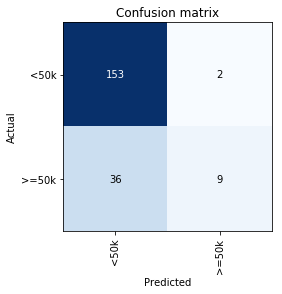

In [ ]:
interp.plot_confusion_matrix()

With tabular problems, looking at each *individual* row will probably not help us much. Instead what **Class Confusion** will do is plot every variable at whatever combination we dictate, and we can see how the distrobution of those variables in our misses changed in relative to our overall dataset distribution. For example, let's explore `>=50k` and `<50k`

In [ ]:
ClassConfusion(interp, ['>=50k', '<50k'], figsize=(12,12))

100%|██████████| 10/10 [00:06<00:00,  1.26it/s]


<Figure size 432x288 with 0 Axes>

![](https://i.imgur.com/iUUSp2A.png)

Now we can see the distrobutions for each of those two missed boxes in our confusion matrix, and look at what is really going on there. If we look at education, we can see that for many times where we thought people were making above or below 50k, they were often graduates of high school and persuing some college degree. 



We can also look at the distrobution for continuous categories as well. Shown below is `age`:

In [ ]:
ClassConfusion(interp, ['>=50k', '<50k'], figsize=(12,12))

100%|██████████| 10/10 [00:06<00:00,  1.29it/s]


<Figure size 432x288 with 0 Axes>

![](https://i.imgur.com/jMiTb3y.png)

If we want to look at specific variables, we pass them into `varlist`. Below is `age`, `education`, and `relationship`:

In [ ]:
ClassConfusion(interp, ['>=50k', '<50k'], varlist=['age', 'education', 'relationship'],
               figsize=(12,12))

100%|██████████| 3/3 [00:01<00:00,  1.40it/s]


<Figure size 432x288 with 0 Axes>

![](https://i.imgur.com/ZIqwljr.png)

We can plot the distrobution for our true positives as well, if we want to compare those by using histograms:

In [ ]:
ClassConfusion(interp, [['>=50k', '>=50k'], ['>=50k', '<50k']], varlist=['age', 'education', 'relationship'],
               is_ordered=True, figsize=(12,12))

100%|██████████| 3/3 [00:01<00:00,  1.49it/s]


<Figure size 432x288 with 0 Axes>

![](https://i.imgur.com/xNUUPz0.png)